In [5]:
!wget https://raw.githubusercontent.com/pSzyc/Ising/main/Model/input_pipeline.py

--2024-02-12 05:39:58--  https://raw.githubusercontent.com/pSzyc/Ising/main/Model/input_pipeline.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2810 (2.7K) [text/plain]
Saving to: ‘input_pipeline.py’

input_pipeline.py   100%[===================>]   2.74K  --.-KB/s    in 0s      

2024-02-12 05:39:58 (29.1 MB/s) - ‘input_pipeline.py’ saved [2810/2810]



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import csv
from google.colab import drive
from pathlib import Path
import sys
import pandas as pd
import seaborn as sns
import glob
import contextlib
from PIL import Image

plt.rcParams['figure.dpi'] = 300

drive.mount('/content/drive', force_remount=True)
drive_path = Path("drive/MyDrive/Licencjat")

Mounted at /content/drive


# Model

In [2]:
class VAE(tf.keras.Model):
  """Variational autoencoder."""

  def __init__(self, latent_dim, kernel_size = 3, lattice_size = 32):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(32, (kernel_size, kernel_size), activation='relu', padding="same", input_shape=(32, 32, 1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(latent_dim + latent_dim)
          ]
     )

    self.decoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=kernel_size, strides=(1, 1), padding="same"),
        ]
    )

  def call(self, inputs):
    mean, logvar = self.encode(inputs)
    z = self.reparameterize(mean, logvar)
    reconstructed = self.decode(z)
    return reconstructed

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Training

In [4]:

def plot_spins(path, predictions, originals):
    fig = plt.figure(figsize=(15, 20))
    subfigs = fig.subfigures(nrows=len(predictions), ncols=1)

    for index, subfig in enumerate(subfigs):
        subfig.suptitle(f'Sample nr: {index}')
        axs = subfig.subplots(nrows=1, ncols=4)

        axs[0].imshow(predictions[index, :, :, 0], vmin=0, vmax=1)
        axs[0].axis('off')
        axs[0].set_title("Spin +1 probability map")

        axs[1].imshow(np.random.binomial(1, predictions[index, :, :, 0]), vmin=0, vmax=1)
        axs[1].axis('off')
        axs[1].set_title("Predicted from binomial")

        axs[2].imshow(predictions[index, :, :, 0] > 0.5, vmin=0, vmax=1)
        axs[2].axis('off')
        axs[2].set_title("p > 0.5")

        axs[3].imshow(originals[index, :, :, 0], vmin=0, vmax=1)
        axs[3].axis('off')
        axs[3].set_title("Original Sample")

    plt.savefig(path)
    plt.show()

def generate_and_save_images(model, epoch, test_sample, results):
  predictions = make_prediction(model, test_sample)
  plot_spins(results / "Images" / f'image_at_epoch_{epoch}_{temp}.png', predictions, test_sample)

def make_prediction(model, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    return predictions

def sample(num_examples_to_generate, model):
    random_mean = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
    log_var = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

    z = model.reparameterize(random_mean, log_var)
    predictions = model.sample(z)
    return predictions

def make_gif(results, temp):
  fp_in = results / f"Images/*.png"
  fp_out = results /  f"train_{temp}.gif"

  # use exit stack to automatically close opened images
  with contextlib.ExitStack() as stack:

      # lazily load images
      imgs = (stack.enter_context(Image.open(f))
              for f in sorted(glob.glob(str(fp_in))))

      # extract  first image from iterator
      img = next(imgs)

      # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
      img.save(fp=str(fp_out), format='GIF', append_images=imgs,
              save_all=True, duration=1000, loop=0)

def calcEnergy(mat):
    '''Energy of a given configuration'''
    matrix_sum = get_neighbour_sum_matrix(mat)
    return - np.sum(np.multiply(matrix_sum, mat))

def calcMag(mat):
    '''Magnetization of a given configuration'''
    mag = np.sum(mat)
    return mag

def get_neighbour_sum_matrix(mat):
    """Matrix of the sum of spin values for all neighboring cells."""
    # Define shifts for different directions
    shifts = [
        (1, 1),  # Right
        (-1, 1),  # Left
        (-1, 0),  # Up
        (1, 0),  # Down
        (-1, 1),  # Up-Right
        (1, 1),  # Down-Right
        (-1, -1),  # Up-Left
        (1, -1),  # Down-Left
    ]

    # Initialize an empty matrix for the sum of neighboring cells
    neighbor_sum = np.zeros_like(mat)

    # Iterate through each shift and accumulate the values in neighbor_sum
    for shift in shifts:
        shifted_mat = np.roll(mat, shift=shift, axis=(0, 1))
        neighbor_sum += shifted_mat

    return neighbor_sum

def cost_function_plot(loss_list, results):
  plt.figure()
  plt.suptitle("Loss function vs Epoch - VAE")
  plt.plot(loss_list)
  plt.xlabel("Epoch")
  plt.ylabel("Cost function")
  plt.savefig(results / "loss_function.png")

def process_data(spin_image):
  df = pd.DataFrame({'image': list(spin_image)})
  df['Magnetization'] = df['image'].apply(calcMag)
  df['Energy'] = df['image'].apply(calcEnergy)
  df.drop(columns='image', inplace=True)
  return df

def sample_data_plots(model, test_size, batch_size, test_set, results):
  sample_data = []
  num = test_size
  for _ in range(batch_size):
    sample_data.append(sample(num, model))
  spin_sample = tf.concat(sample_data, axis = 0)
  preds = []
  reals = []
  for test_x in test_set:
    preds.append(make_prediction(model, test_x))
    reals.append(test_x)

  predicted_spin = np.concatenate(preds)
  real_spin = np.concatenate(reals)
  predicted_spin =  2 * np.random.binomial(1, predicted_spin) - 1
  real_spin =  2 * real_spin - 1
  spin_sample = 2 * np.random.binomial(1, spin_sample) - 1
  df = get_statistics_df(predicted_spin, real_spin, spin_sample)
  sns.displot(df, x = 'Magnetization', kind ='kde', hue='Algorithm')
  plt.savefig(results / f"mag_{temp}.png")
  sns.displot(df, x = 'Energy', kind ='kde', hue='Algorithm')
  plt.savefig(results / f"energy_{temp}.png")

def get_statistics_df(perdicted_spin, real_spin, spin_sample):
  df_model = process_data(perdicted_spin)
  df_model['Algorithm'] = 'VAE testset'

  df_test = process_data(real_spin)
  df_test['Algorithm'] = 'Wolff testset'

  df_sample = process_data(spin_sample)
  df_sample ['Algorithm'] = 'VAE sample'

  df = pd.concat([df_model, df_test, df_sample])
  return df

In [5]:
def load_starting_weights(model):
    dummy_input = tf.zeros((1, 32, 32, 1))
    model(dummy_input)
    model.load_weights(drive_path / "Results" / "reference" / "vae2.2.h5")

# Dataset

In [6]:
from IPython import display
from time import time
from queue import Queue
from input_pipeline import dataset_tfrecord_pipeline

def train_at_t(temp, model, batch_size = 100, epochs = 50, latent_dim = 200, num_examples_to_generate = 5, test_size = 100):
  # Folders for storing the results and dataset
  trainset_path = drive_path / "data" /  f"Data{temp}.tfrecord"

  results = drive_path / "Results" / str(temp)
  results.mkdir(exist_ok = True )

  images = results / "Images"
  images.mkdir(exist_ok = True)

  train_set = dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
  test_set = train_set.take(test_size)
  loss_monitor = 3 * [False]

  # Test sample for image generation
  assert batch_size >= num_examples_to_generate
  for test_batch in test_set.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]
  generate_and_save_images(model, 0, test_sample, results)

  # Training loop
  loss_list = []
  for epoch in range(1, epochs + 1):
    time_start = time()
    for train_x in train_set:
      train_step(model, train_x, optimizer)
    loss = tf.keras.metrics.Mean()
    for test_x in test_set:
      loss(compute_loss(model, test_x))

    elbo = -loss.result()
    loss_list.append(loss.result().numpy())

    if epoch > 1:
      loss_monitor.pop(-1)
      loss_monitor.insert(0, loss_list[-1] - loss_list[-2] > 0)
      if all(loss_monitor):
        print("STOP!")
        break

    display.clear_output(wait=False)
    generate_and_save_images(model, epoch, test_sample, results)
    elapsed = time() - time_start
    print(f'Epoch: {epoch}, Test set ELBO: {elbo}, Time needed: {elapsed}')

  # Results
  make_gif(results, temp)
  cost_function_plot(loss_list, results)
  sample_data_plots(model, test_size, batch_size, test_set, results)
  model.save_weights(results / f'vae{temp}.h5',save_format='h5')


In [7]:
temps = [2.1, 2.2]
model = VAE(200, lattice_size = 32)
optimizer = tf.keras.optimizers.Adam(1e-4)

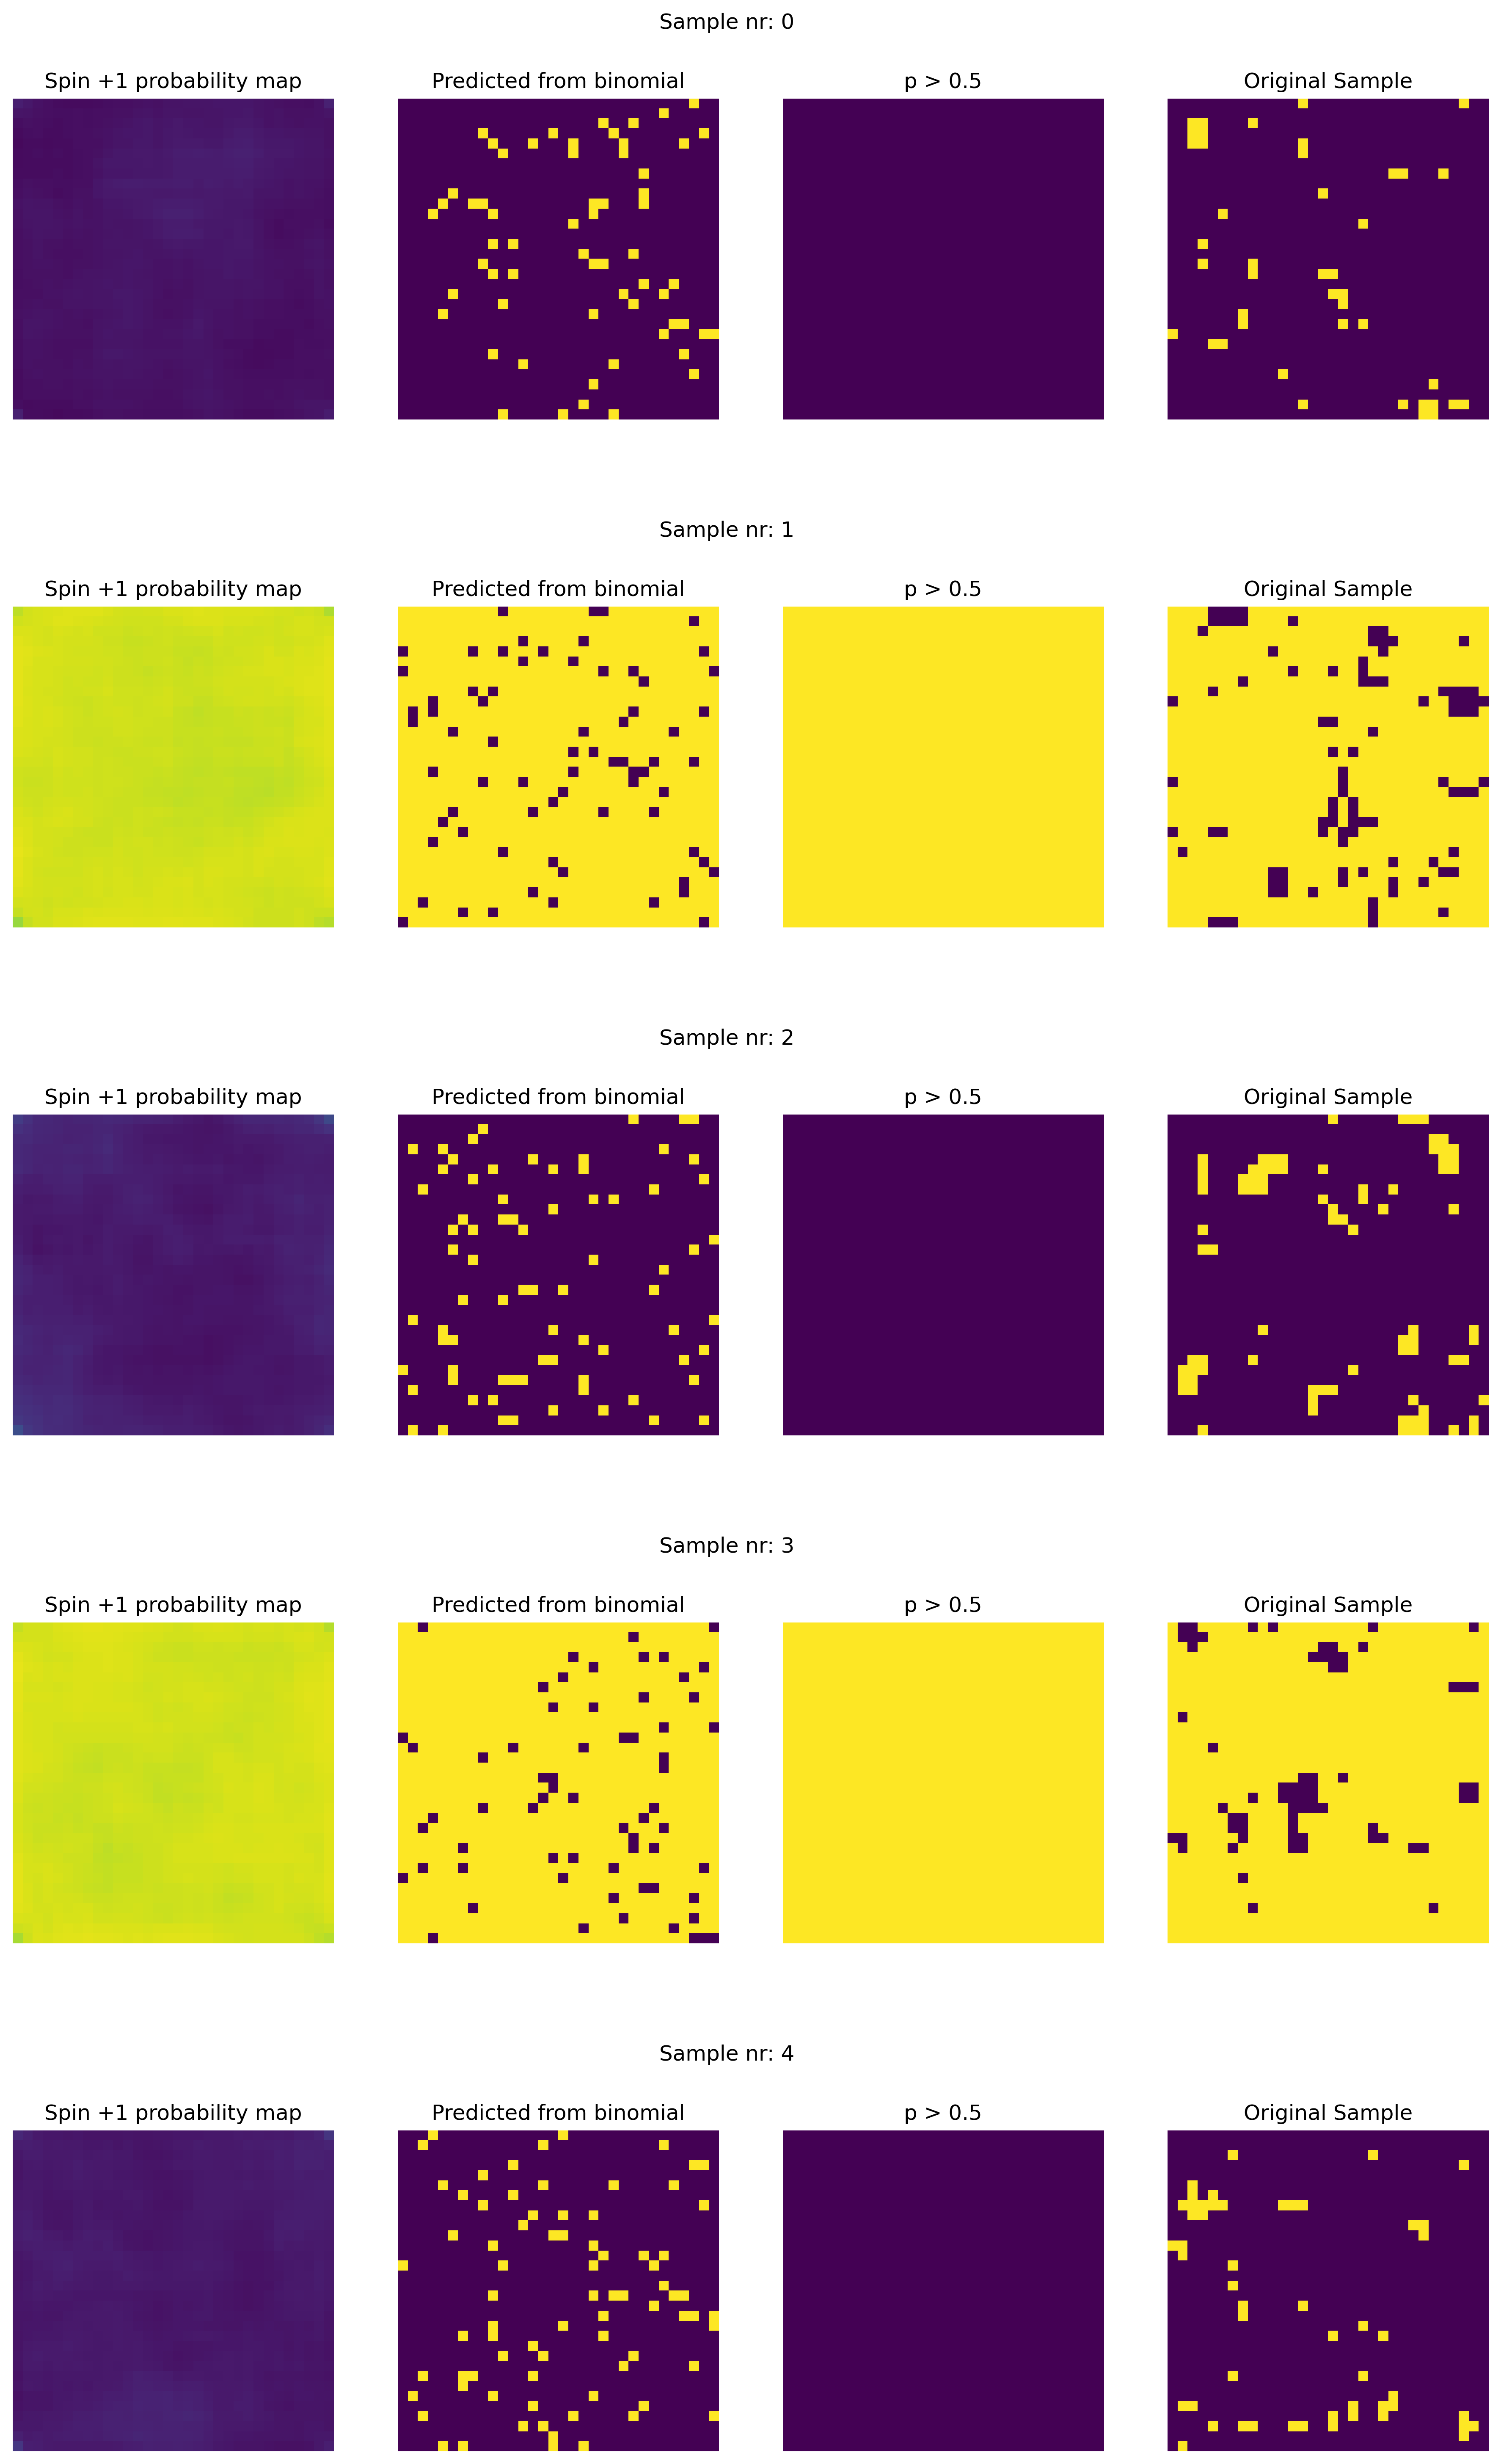

Epoch: 1, Test set ELBO: -256.137451171875, Time needed: 424.1926441192627


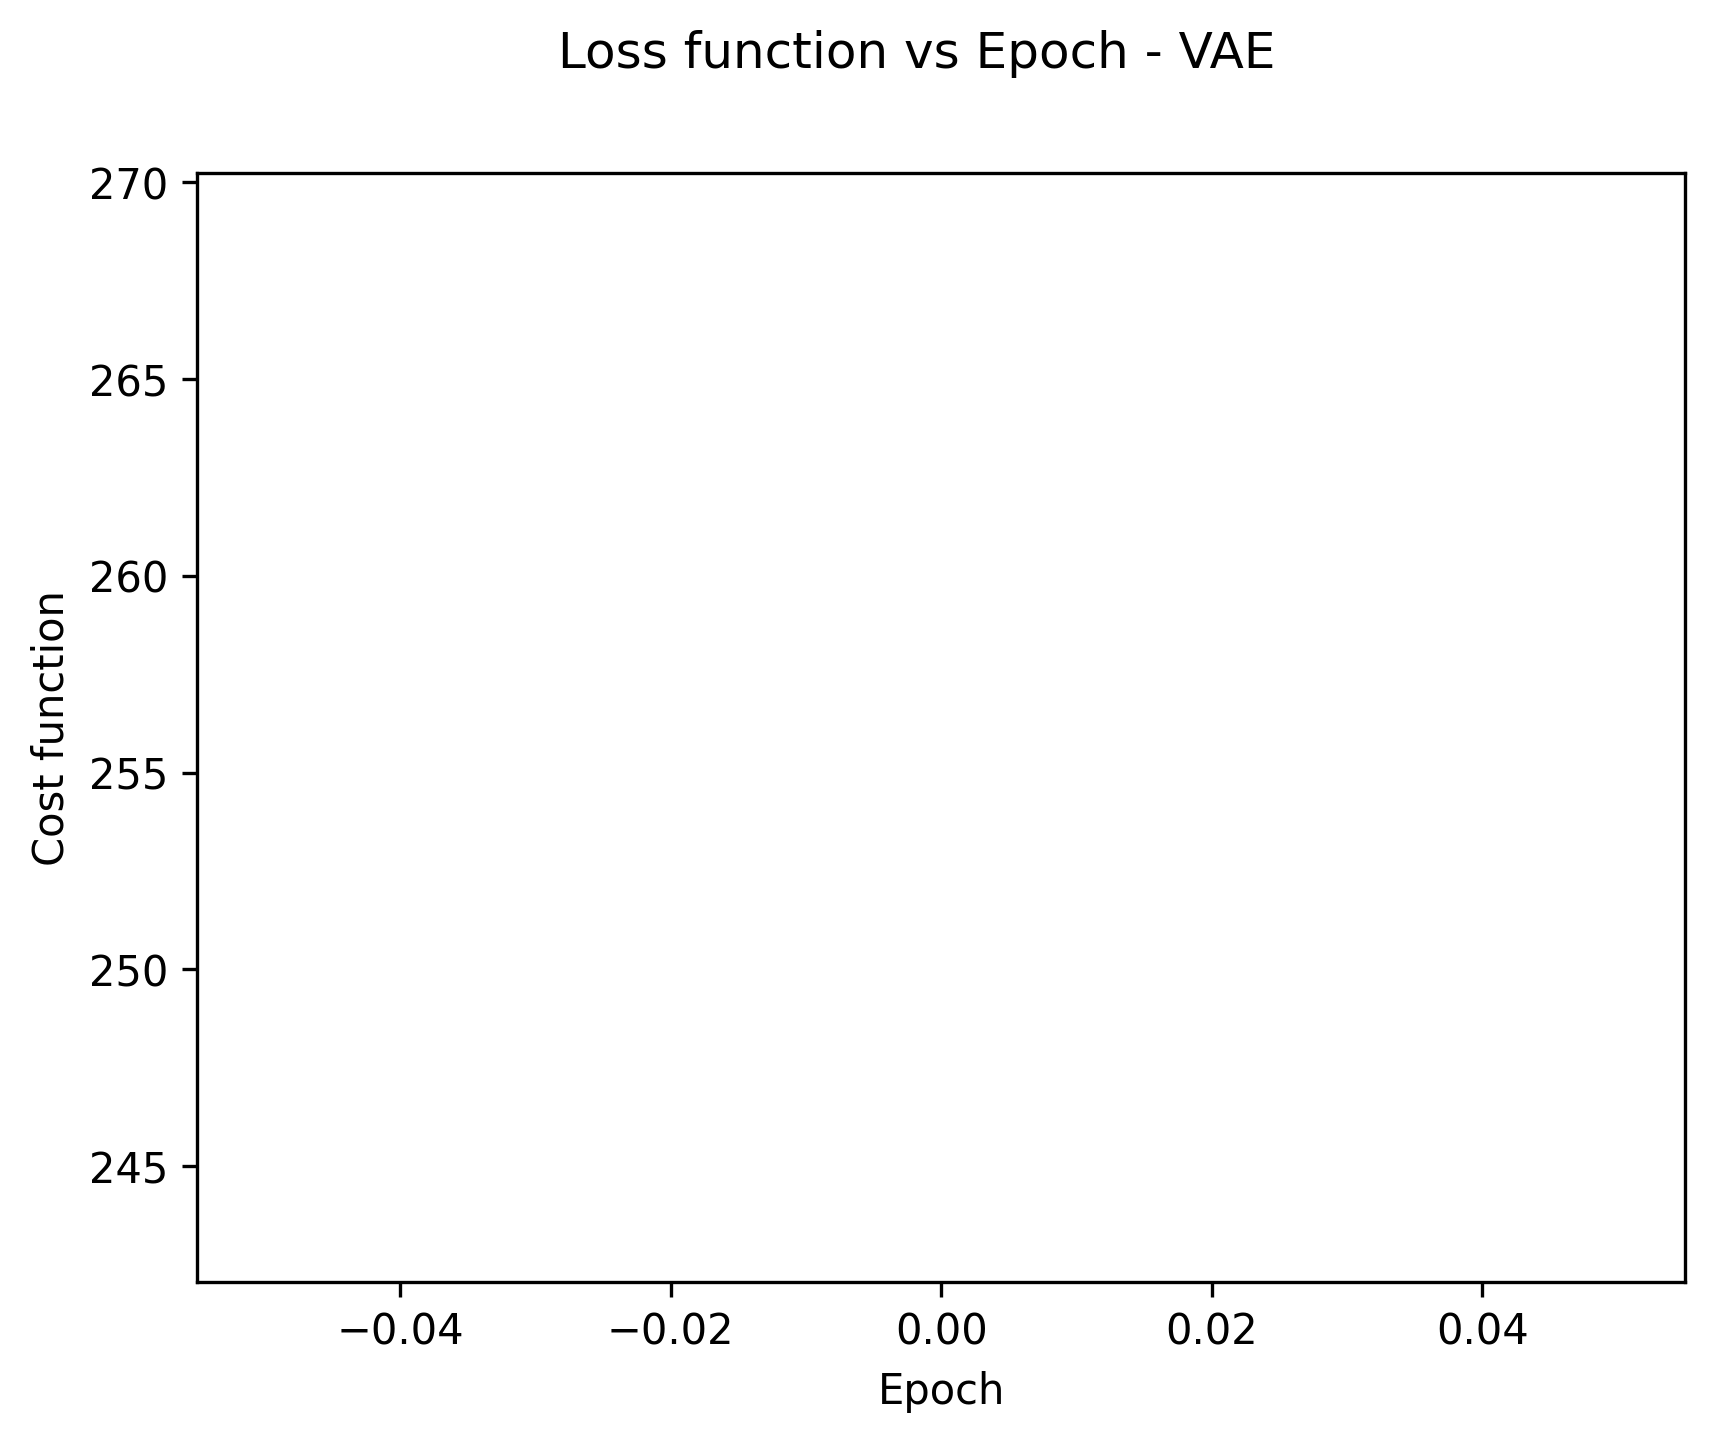

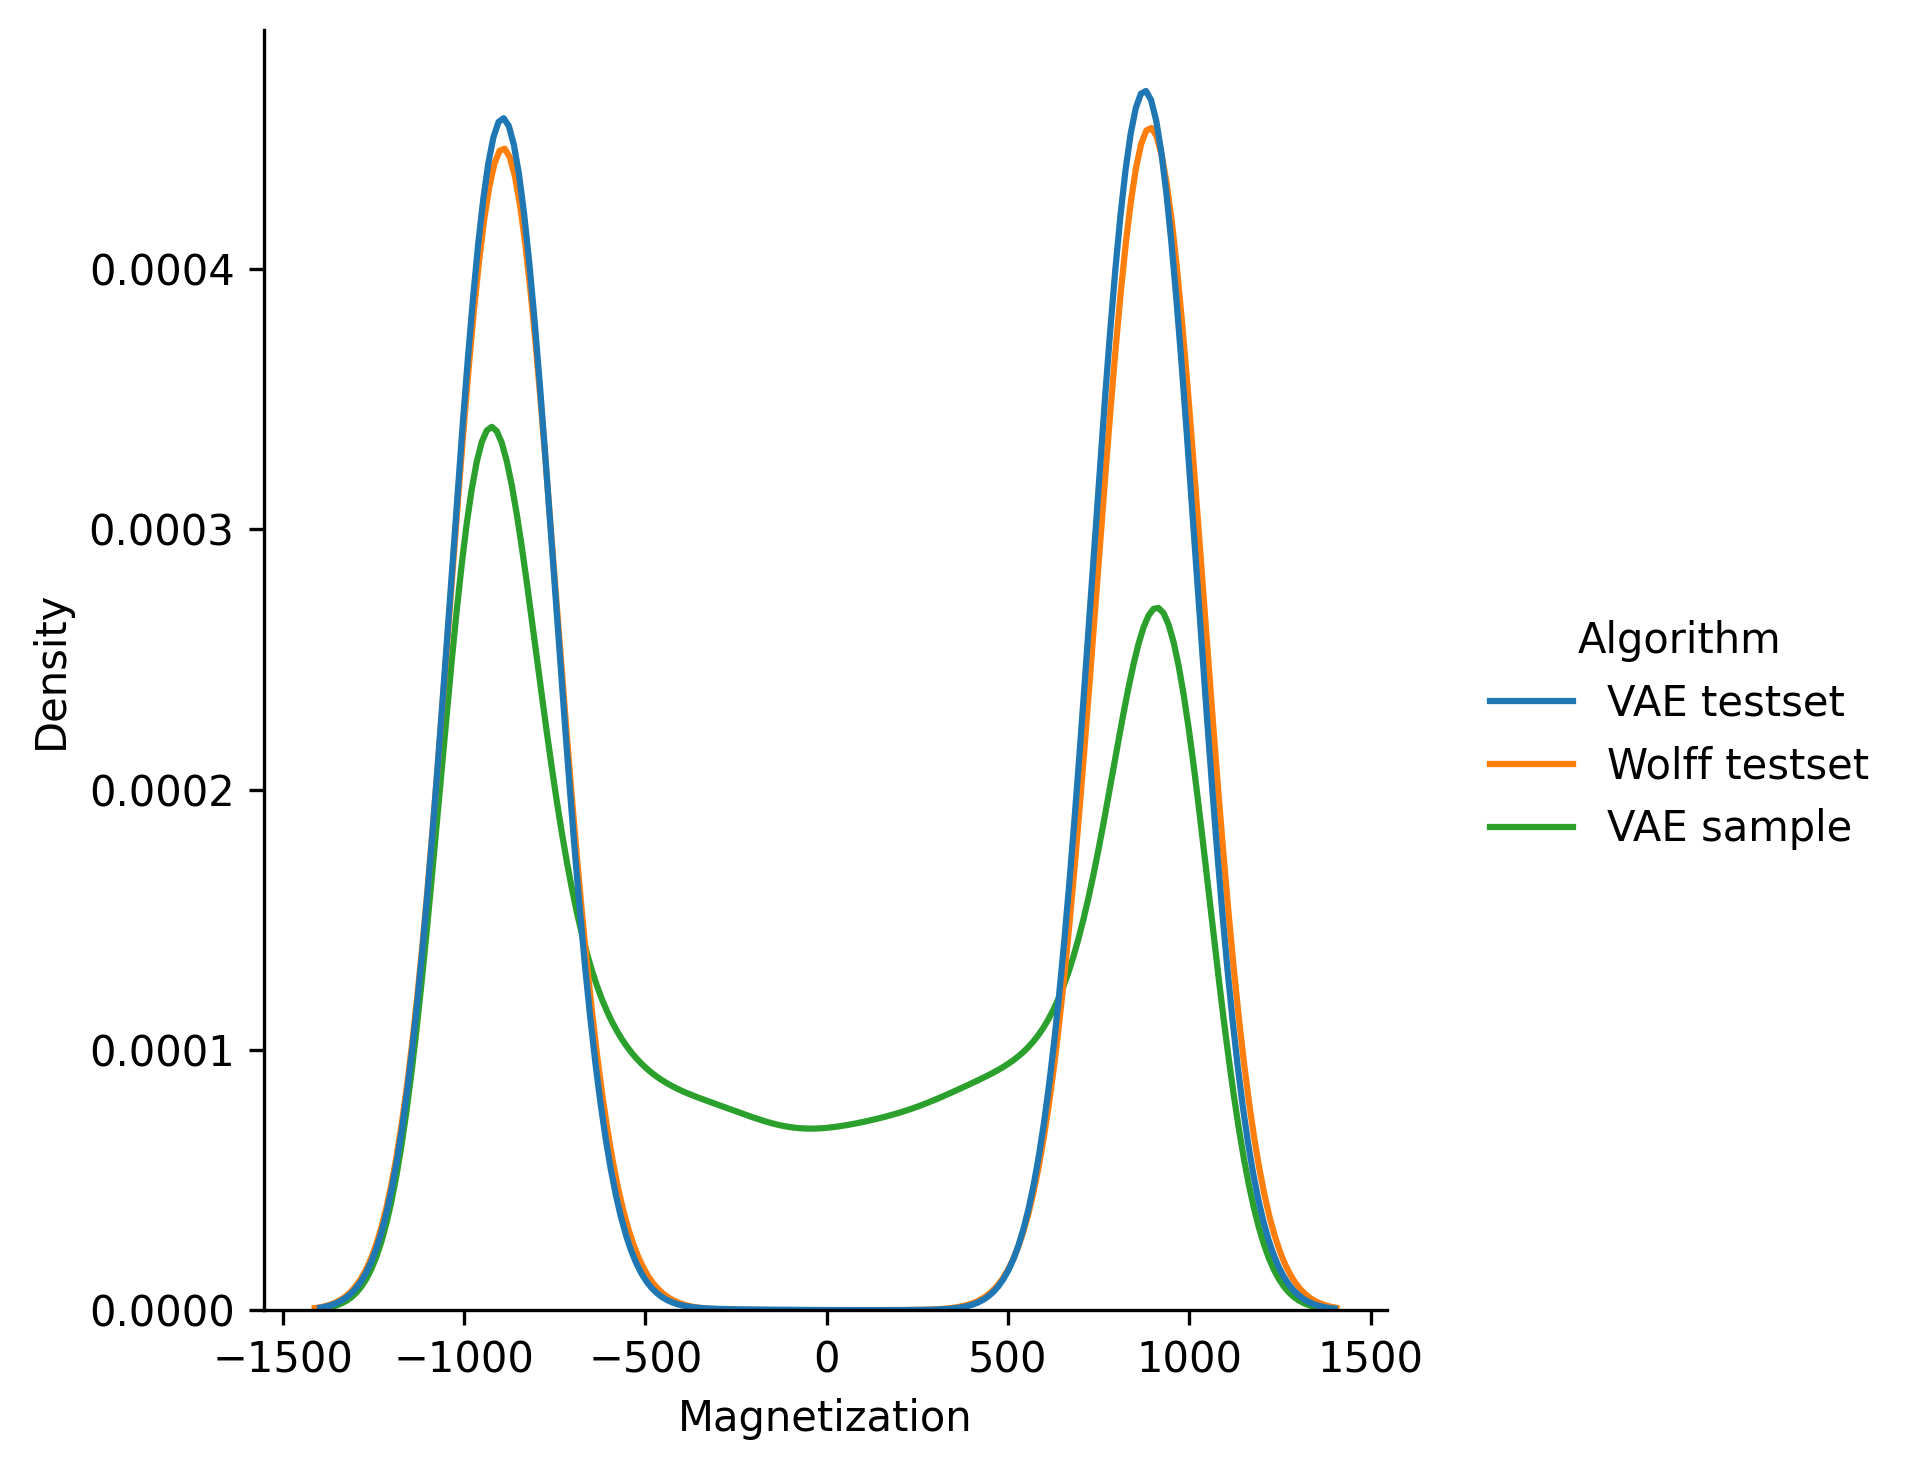

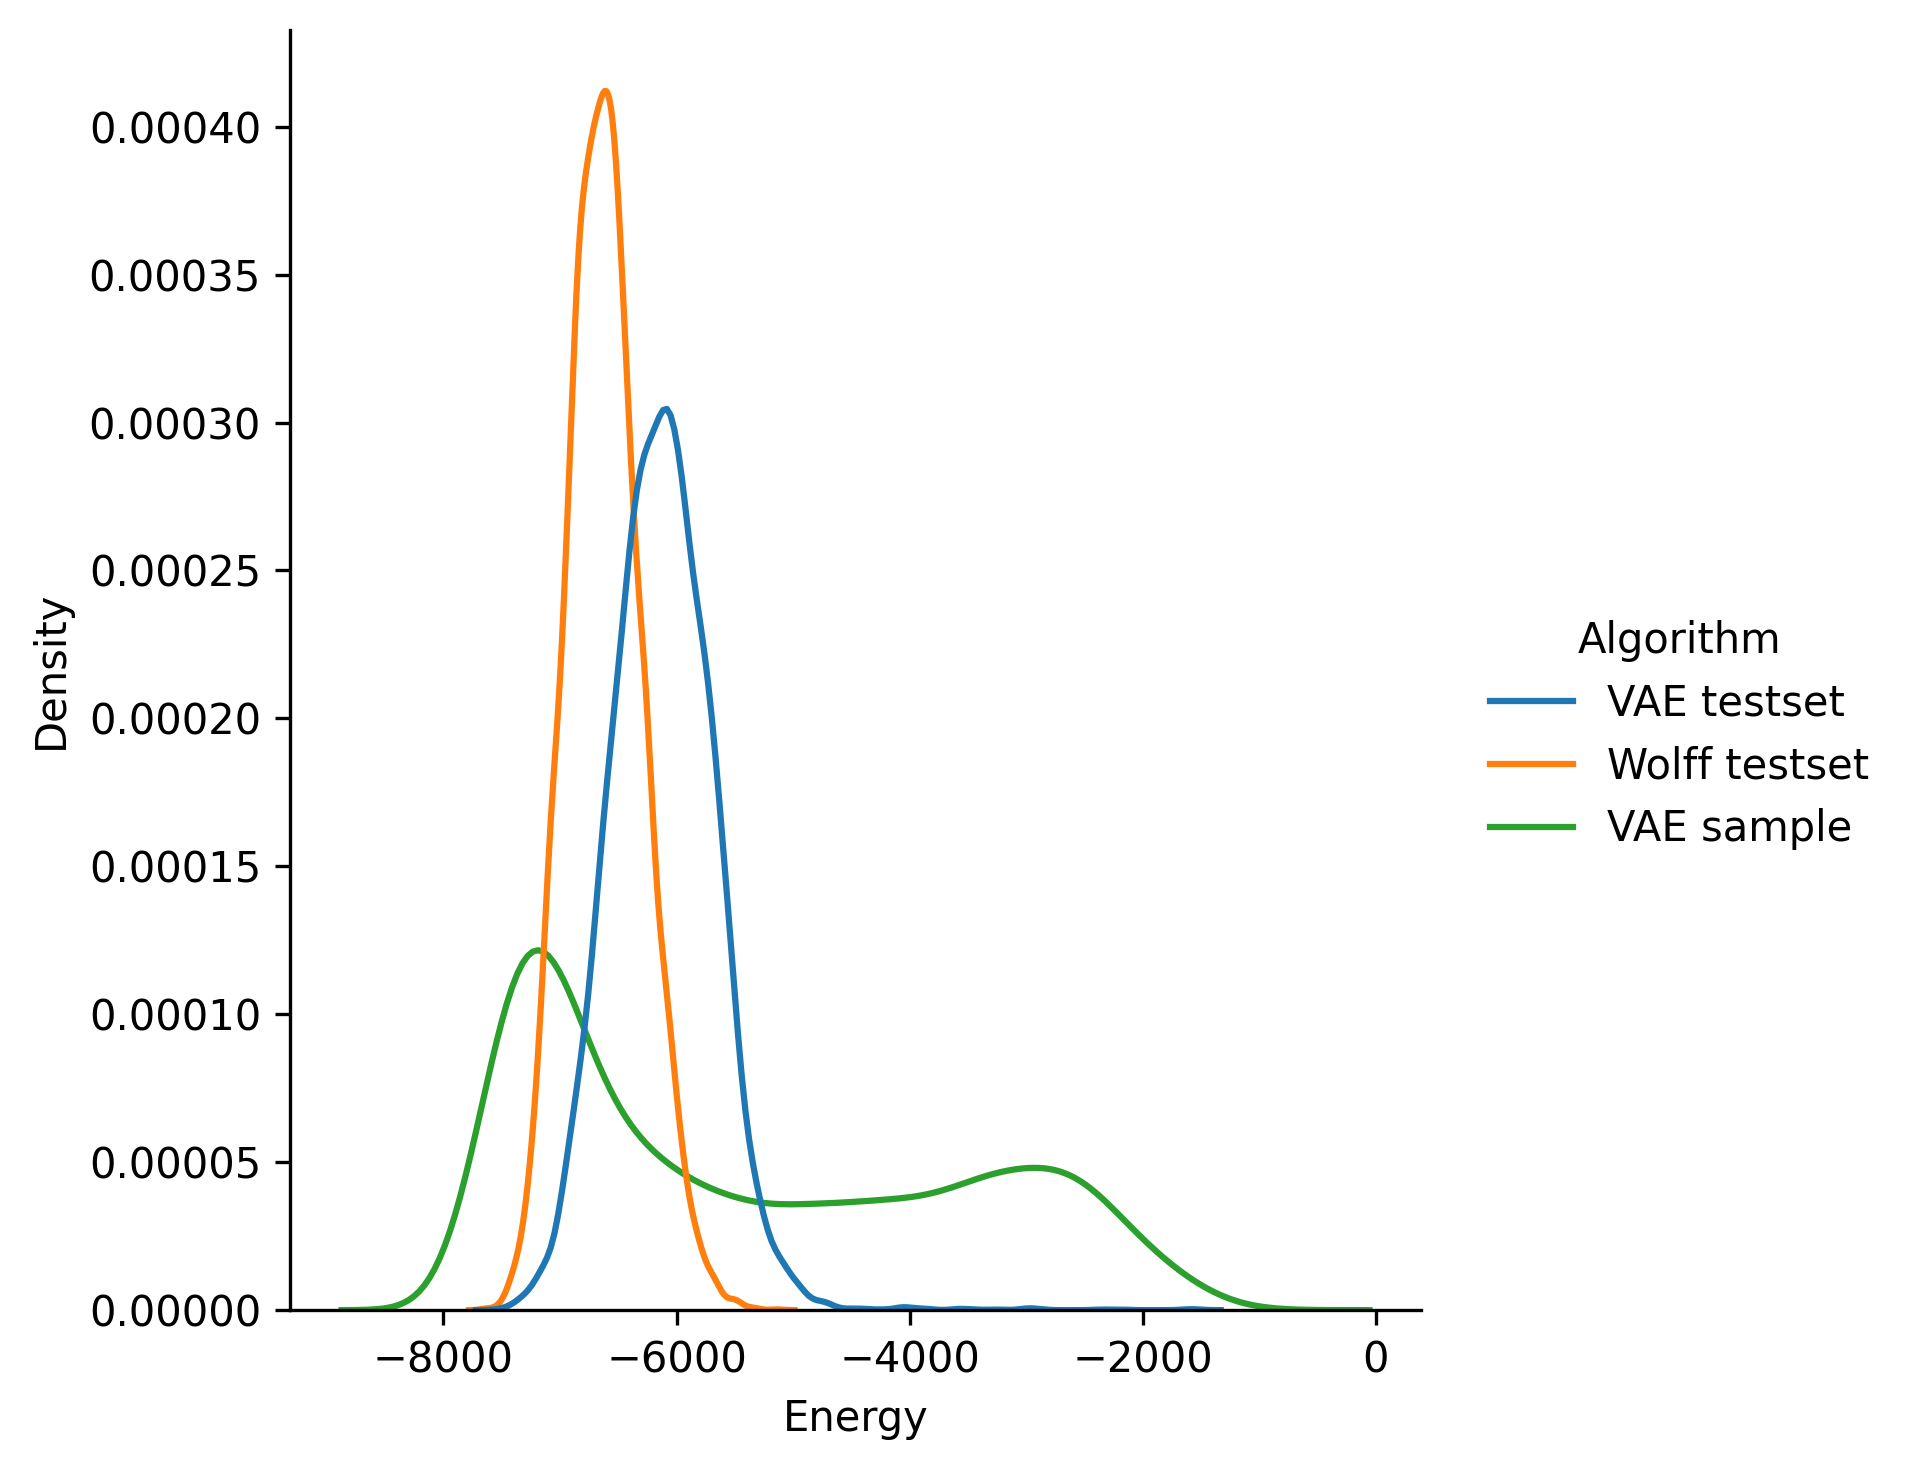

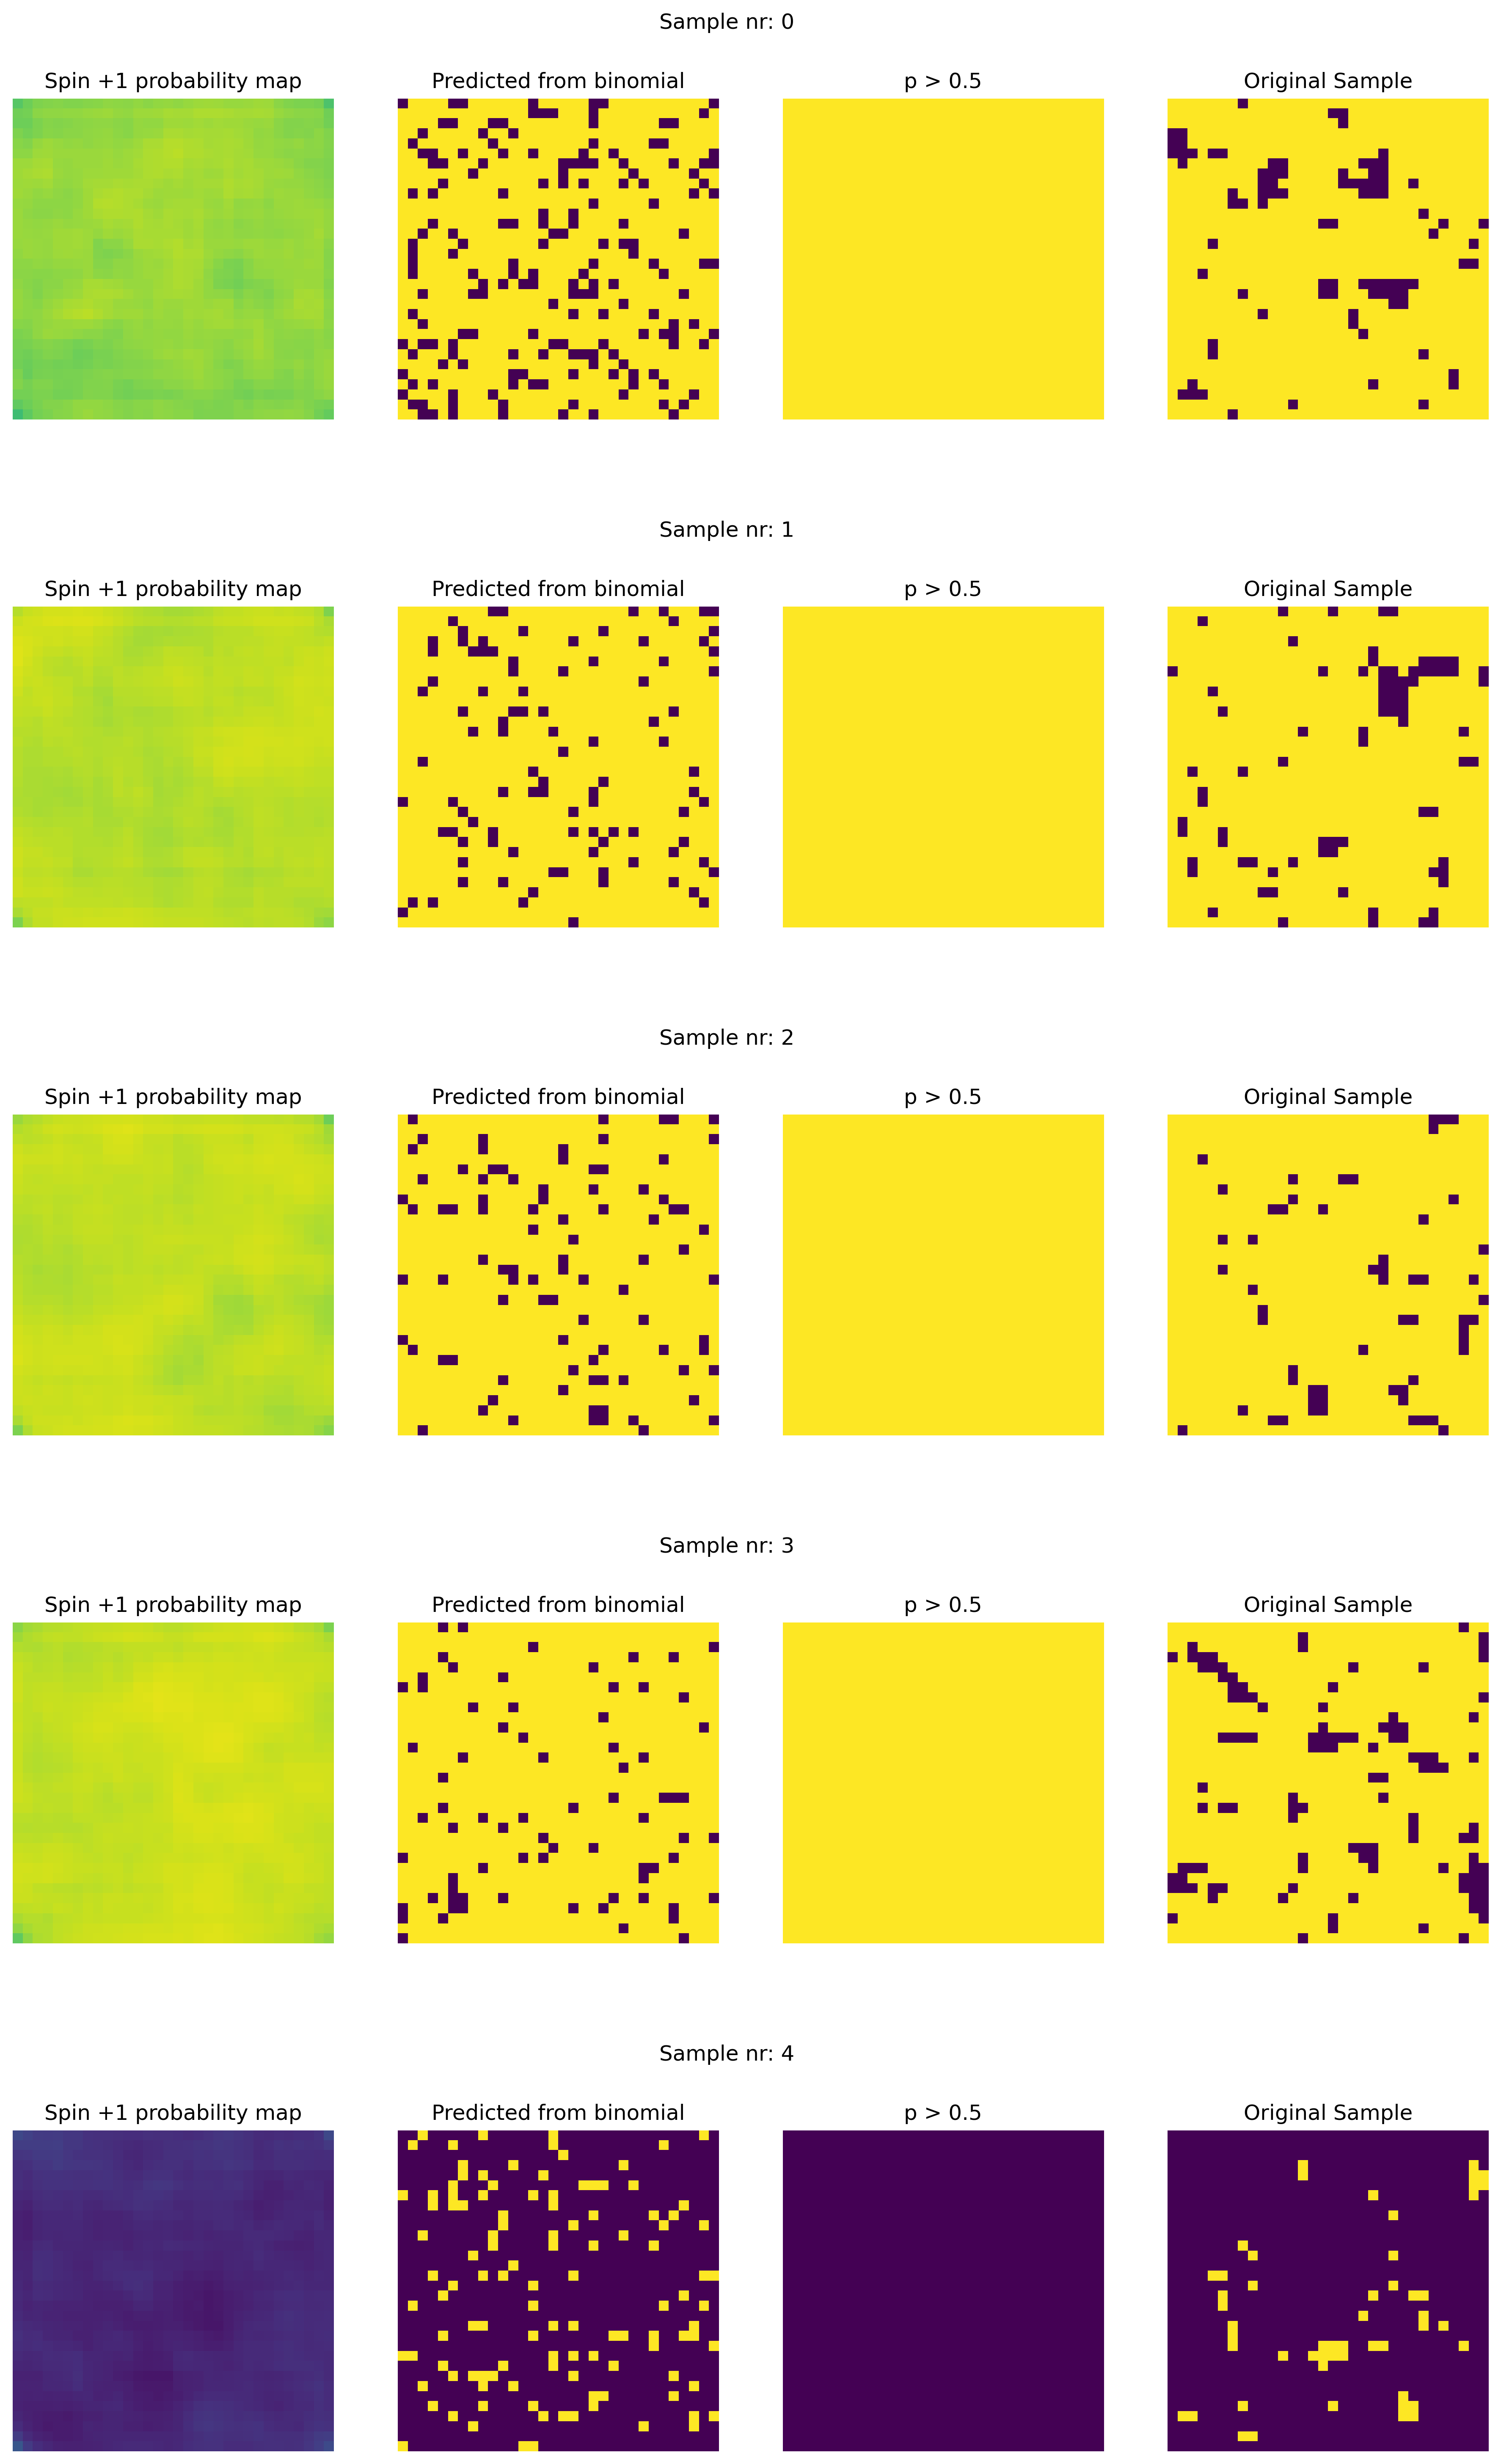

In [ ]:
epochs = 1
latent_dim = 200
num_examples_to_generate = 5
batch_size = 100

for i, temp in enumerate(temps):
  load_starting_weights(model)
  train_at_t(temp, model, batch_size, epochs, latent_dim, num_examples_to_generate)